In [1]:
%config IPCompleter.greedy=True

# Phase 3 Project
## Ryan McArthur, DS FT 081720
### Instructor : Rafa Carrasco

# SyriaTel Customer Churn 

* Build a classifier to predict whether a customer will ("soon") stop doing business with SyriaTel, a telecommunications company. Note that this is a binary classification problem.

* Most naturally, your audience here would be the telecom business itself, interested in losing money on customers who don't stick around very long. Are there any predictable patterns here?

In this investigation on churn for SyriaTel, we will be predicting whether or not a customer will be cancelling their phone plan with SyriaTel. In order to accomplish this, we have been provided with a dataset that includes information regarding customers' phone plan specifics, their phone usage, and their service history. 

Furthermore, we will be providing recommendations on how SyriaTel may retain customers more efficiently through the lens of our model. We will inspect which variables had large impacts on customers' decisions to cancel their plan, and suggest campaigns or incentives that will most likely change our customers decisions to leave the service, or retain existing customers for a longer period. 

Finally, we will request additional resources or information for SyriaTel to gather in order to show how this process could have been, or could be, improved upon for further investiations.

# Data Info

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

df = pd.read_csv('Data/telecom_data.csv')
df.shape

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [3]:
# we rename columns to work with pandas

df.columns = df.columns.str.strip().str.replace(' ', '_')

Our data is collected from a telecom provider with national coverage, representing one month's worth of data on a customer, describing the plan, usage, and service details. The data is split into three types: customer data, plan specifics, and usage data. 
#### Customer Data:
* state
* area_code
* phone_number
* customer_service_calls

#### Plan Specifics:
* international_plan
* voice_mail_plan



#### Usage Data:
* number_vmail_messages
* total_day_minutes
* total_day_calls
* total_day_charge
* total_eve_minues
* total_eve_calls
* total_eve_charge
* total_night_minutes
* total_night_calls
* total_night_charge
* total_intl_minutes
* total_intl_calls
* total_intl_charge




In [4]:
# we establish placeholder cat/num lists for use in later for loops

catts = []
numms = []

# we fill the lists

for i in df.columns:
    if df[i].dtype == 'object':
        catts.append(i)
    else:
        numms.append(i)

In [5]:
# we move 'area_code' to categorical

catts.append('area_code')
numms.remove('area_code')

df['area_code'] = df['area_code'].astype('object')

# Data Cleaning

In [37]:
# we inspect our dataframe

df.account_length.describe()

count    3333.000000
mean      101.064806
std        39.822106
min         1.000000
25%        74.000000
50%       101.000000
75%       127.000000
max       243.000000
Name: account_length, dtype: float64

In [7]:
# we define a function for dropping columns safely. We drop 'phone_number' because this is just a unique identifier

def drop_cols(df, columns):
    for col in columns:
        if col in df.columns:
            df.drop(columns = col, inplace = True)
        if col in catts:
            catts.remove(col)
        if col in numms:
            numms.remove(col)
        else:
            pass
drop_cols(df, ['phone_number'])
df


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


We need to address 'area_code', a problematic column. There are only three unique values in this column, all area codes belonging to the San Francisco Bay area, while we also have the 'states' column that contradicts this fact, as there are customers all over the US. Because of this, we will be dropping 'area_code' and utilizing 'state' as our sole location predictor. 

In [8]:
# we drop "area_code", due to it's inherent conflict with 'states'

df = df.drop('area_code', axis = 1)

In [9]:
# we change 'churn' from bool to int

df['churn'] *= 1

# we change 'international_plan' and 'voice_mail_plan' from object to int and verify with .astype()

for i in range(len(df)):
    
    if df['international_plan'][i] == 'yes':
        df['international_plan'][i] = 1
    else: 
        df['international_plan'][i] = 0
    
    if df['voice_mail_plan'][i] == 'yes':
        df['voice_mail_plan'][i] = 1
    else: 
        df['voice_mail_plan'][i] = 0
        
df[['churn', 'international_plan', 'voice_mail_plan']].astype(int)

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

,churn,international_plan,voice_mail_plan
0,0,0,1
1,0,0,1
2,0,0,0
3,0,1,0
4,0,1,0
...,...,...,...
3328,0,0,1
3329,0,0,0
3330,0,0,0
3331,0,1,0


In [10]:
# we construct features 'total_charge', 'total_calls', 'total_minutes' and add these columns to our numerical predictors list

df['total_charge'] = df.total_day_charge+df.total_eve_charge+df.total_night_charge+df.total_intl_charge
df['total_calls'] = df.total_day_calls+df.total_eve_calls+df.total_night_calls+df.total_intl_calls
df['total_minutes'] = df.total_day_minutes+df.total_eve_minutes+df.total_night_minutes+df.total_intl_minutes

numms.append('total_charge')
numms.append('total_minutes')
numms.append('total_calls')

In [11]:
# we check for any null values or any duplicate values and find neither

df.columns[df.isnull().any()]

df.duplicated().sum()

0

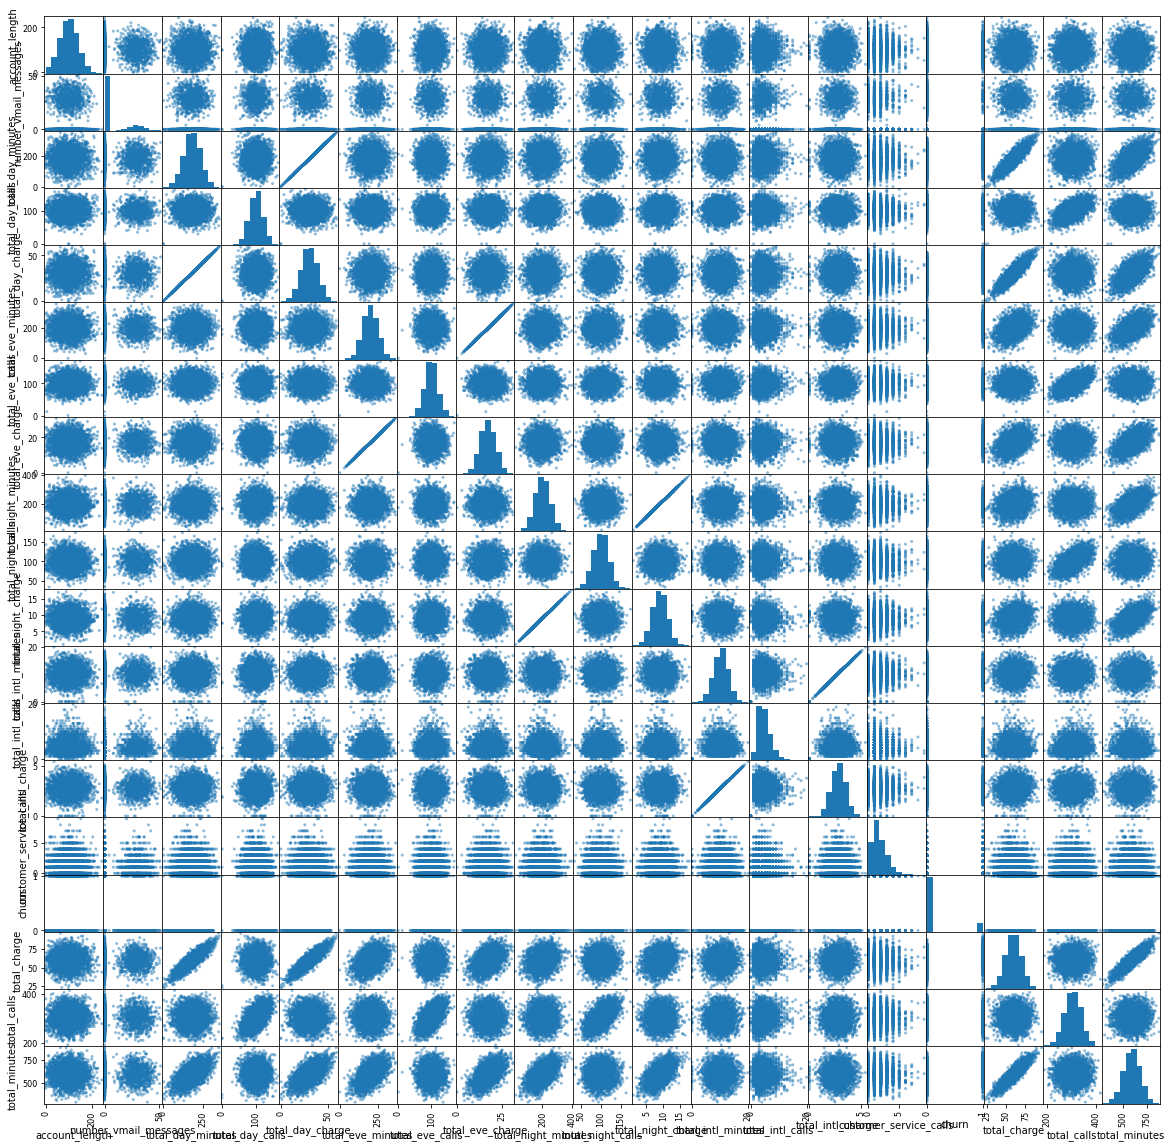

In [12]:
# we plot a scatter matrix to inspect distributions of predictors

pd.plotting.scatter_matrix(df, figsize = (20, 20))
plt.show()


The followig columns are not normally distributed:
* number_vmail_messages
* customer_service_calls

# Exploratory Data Analysis
## Total Charge investigation
### How does Total Charge relate to customer churn?

In [13]:
# we compare descriptive statistics for customers who churn vs customers who do not. 

df['total_charge'].where(df['churn'] == 1).describe()

count    483.000000
mean      65.355963
std       13.885268
min       22.930000
25%       53.425000
50%       66.910000
75%       76.655000
max       96.150000
Name: total_charge, dtype: float64

In [14]:
df['total_charge'].where(df['churn']==0).describe()

count    2850.000000
mean       58.448807
std         9.458436
min        23.250000
25%        52.220000
50%        58.920000
75%        65.137500
max        87.290000
Name: total_charge, dtype: float64

Text(0.5, 6.79999999999999, 'Total Charge')

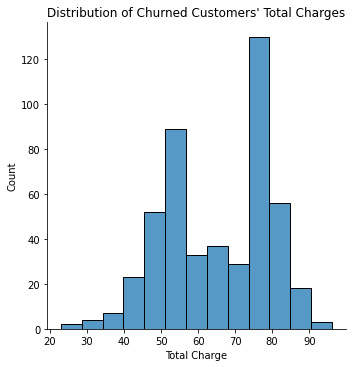

In [38]:
# we visualize the distribution of our churned customers charges

sns.displot(data = df.where(df['churn']==1), x = 'total_charge')
plt.title("Distribution of Churned Customers' Total Charges")
plt.xlabel('Total Charge')

Text(0.5, 6.79999999999999, 'Account Length (months)')

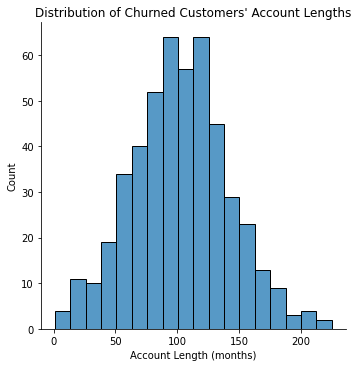

In [41]:
# we visualize the distribution of churned customers account_length

sns.displot(data = df.where(df['churn']==1), x = 'account_length')
plt.title("Distribution of Churned Customers' Account Lengths")
plt.xlabel('Account Length (months)')

Text(0.5, 6.79999999999999, 'Total Charge')

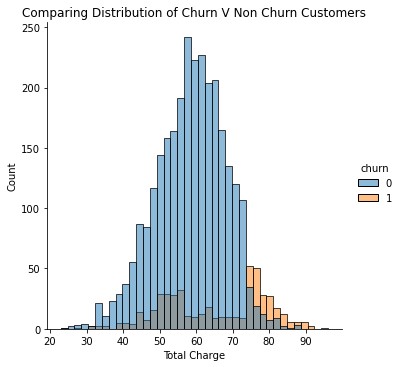

In [16]:
# we compare churned customers v retained customers

sns.displot(data = df, x = 'total_charge', hue = 'churn')
plt.title('Comparing Distribution of Churn V Non Churn Customers')
plt.xlabel('Total Charge')

<AxesSubplot:xlabel='customer_service_calls', ylabel='total_charge'>

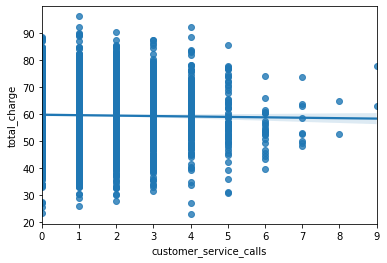

In [17]:
# we check for relationships between total_charge and other predictors, finding none

sns.regplot(data = df, x = 'customer_service_calls', y = 'total_charge')

<AxesSubplot:xlabel='account_length', ylabel='total_charge'>

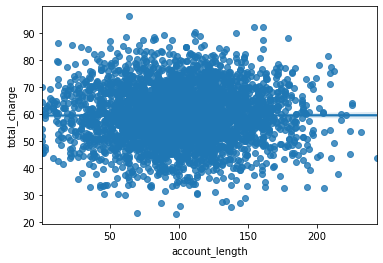

In [18]:
sns.regplot(data = df, x = 'account_length', y = 'total_charge')

#### Conclusions on Total_Cost investigation
* The distribution of churned customers suggests that there are two different clusters of payments. Because of this, we expect that some sort of promotional campaign was in place during the last month for SyriaTel customers. These customers were paying less for a promotional period, then either churned out, resulting in the lower of the two clusters, or stayed on and churned later on, resulting in the second cluster. 
* On average, customers who churn pay more than retained customers. 

## Extra Plan Investigation
### Does being enrolled in an additional service (Voicemail or International) contribute to churn or retention?

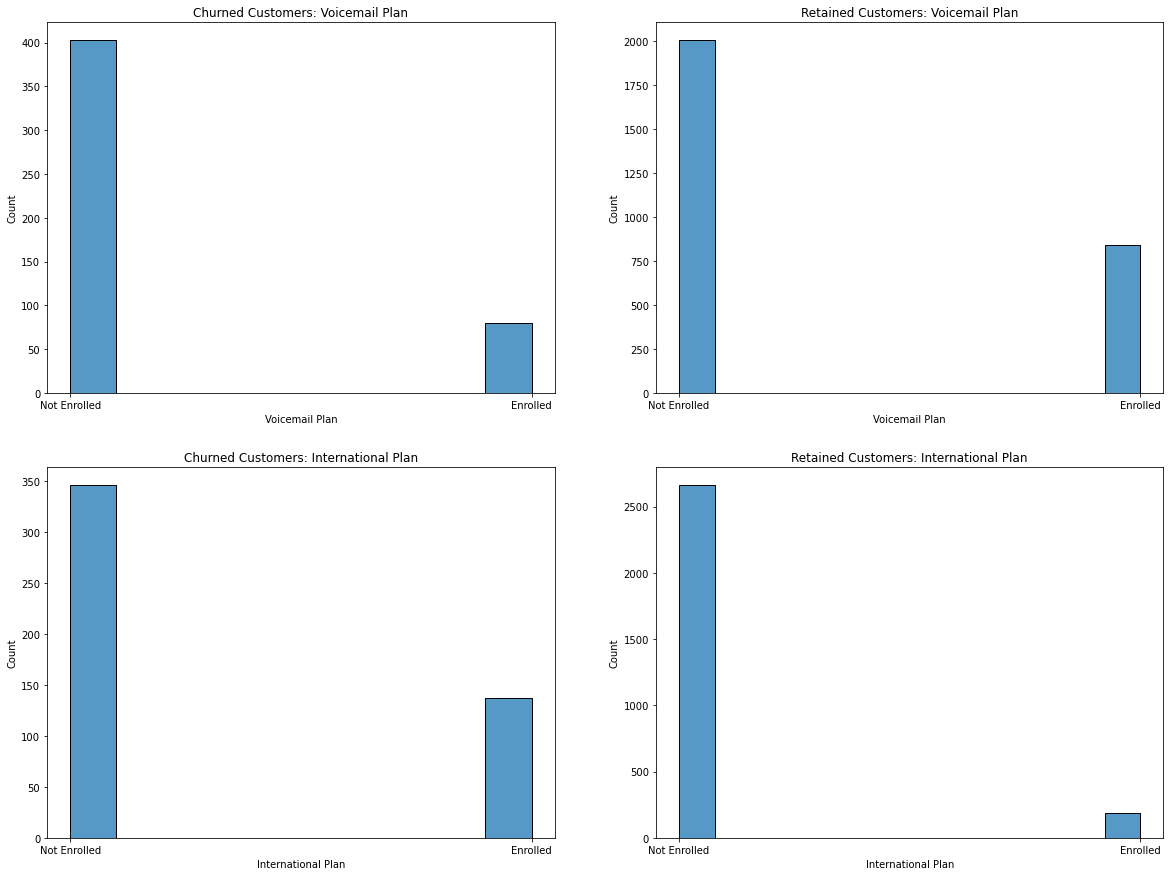

In [29]:
# we visualize the different types of customers and plans, finding that international subscribers are extremely unhappy

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 15))

x_range = [0, 1]
x_labels = ['Not Enrolled', 'Enrolled']

sns.histplot(ax = axes[0][0], data = df.where(df['churn']==1), x = 'voice_mail_plan').set(xlabel = "Voicemail Plan", xticks=x_range, xticklabels = x_labels, title = 'Churned Customers: Voicemail Plan')
sns.histplot(ax = axes[0][1], data = df.where(df['churn']==0), x = 'voice_mail_plan').set(xlabel = "Voicemail Plan", xticks=x_range, xticklabels = x_labels, title = 'Retained Customers: Voicemail Plan')
sns.histplot(ax = axes[1][0], data = df.where(df['churn']==1), x = 'international_plan').set(xlabel = "International Plan", xticks=x_range, xticklabels = x_labels, title = 'Churned Customers: International Plan')
sns.histplot(ax = axes[1][1], data = df.where(df['churn']==0), x = 'international_plan').set(xlabel = "International Plan", xticks=x_range, xticklabels = x_labels, title = 'Retained Customers: International Plan')
plt.show()



In [36]:
# we find the percentage of international customers who churned this month

df_intl = df.where(df['international_plan'] == 1)
df_intl = df_intl.dropna()

df_intl['churn'].sum() / len(df_intl)

0.4241486068111455

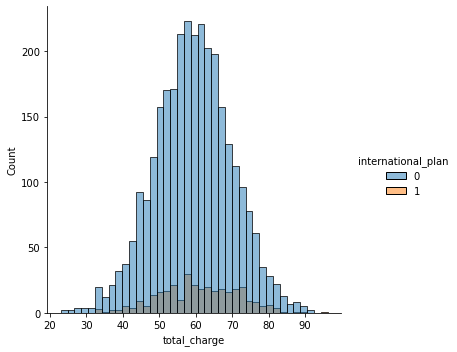

In [20]:
sns.displot(data = df, x = 'total_charge', hue = 'international_plan')

#### Conclusions on Plan Investigation:
* Customers are genearally satisfied with SyriaTel's voicemail plan. This is shown by rthe high ratio of enrolled customers in our 'Retained Customers: Voicemail Plan' visualization.
* Conversely, customers are very unsatisfied with SyriaTel's international plan. This is shown for the same reason, the high ratio of enrolled customers in our 'Churned Customers: International Plan' visualization.


## Location Investigation
### What does each state pay for their phone service on average?
### What is the churn rate by state?
### How does churn relate to total charge?

In [21]:
# we construct a dataframe that contains state and total charge by state

df_states = pd.DataFrame(df.groupby('state')['total_charge'].mean())
df_states = df_states.sort_values(['total_charge'])
df_states = df_states.reset_index()

# we add a column for number of churned customers by state

df_states_churn = pd.DataFrame(df.groupby('state')['churn'].sum())
df_states_churn = df_states_churn.sort_values(['churn'])
df_states_churn = df_states_churn.reset_index()
df_states['churn_sum'] = df_states_churn['churn']

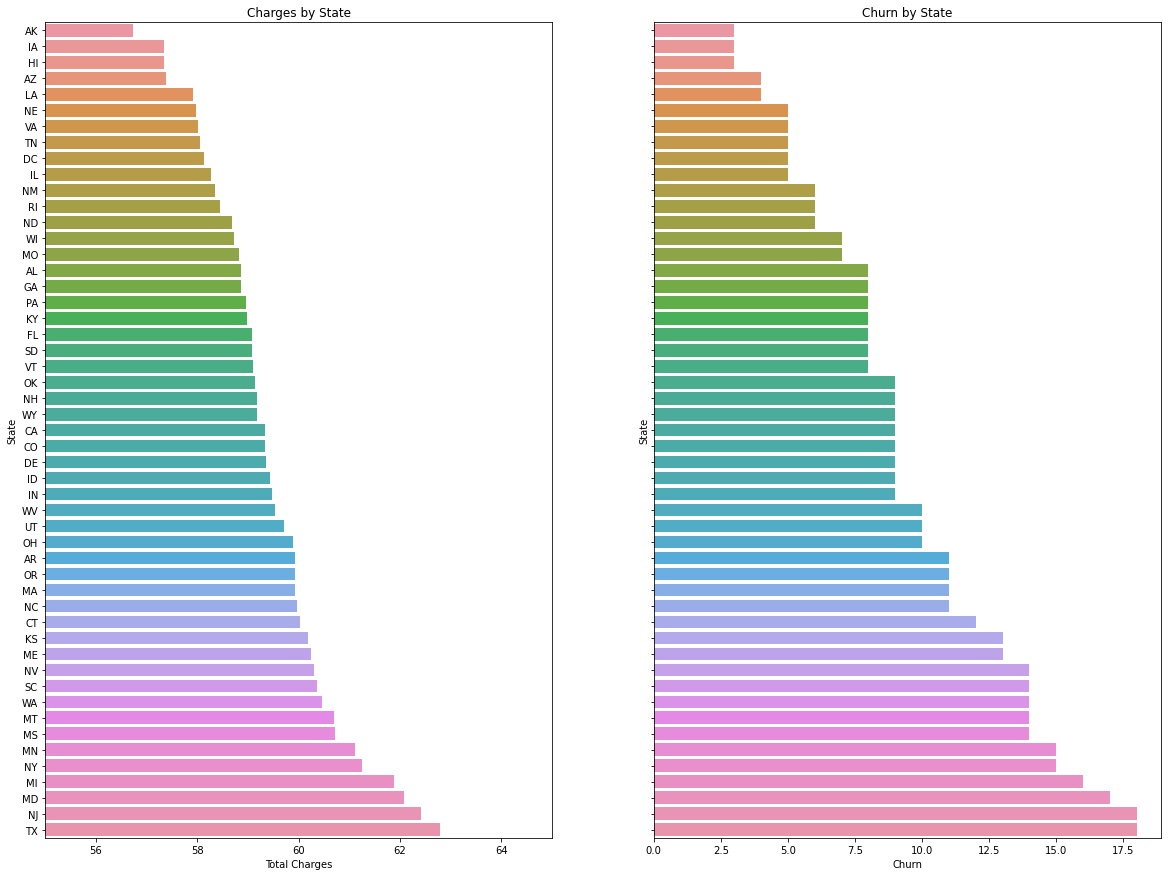

In [22]:
# we visualize the above dataframe

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 15), sharey = True)
sns.barplot(ax = axes[0], y = df_states['state'], x = df_states['total_charge']).set(xlim = [55, 65], title = "Charges by State", xlabel = "Total Charges", ylabel = 'State')
sns.barplot(ax = axes[1], y = df_states_churn['state'], x = df_states_churn['churn']).set(title = 'Churn by State', xlabel = "Churn", ylabel = 'State')
plt.show()


### Conclusions on Location Investigation
* While there is no real trend for churn or payments geographically (the distribution of payments is generally random), we can see that the relationship between large charges and churn is positive. 

A note on our features:
* We need to choose between using totals versus breakdowns of minutes, charge, and calls. Including all of these columns will lead to intense multicollinearity issues, so it is best to drop what will impede us now. 
* let us drop charge breakdowns, using only Total_charge. 
* let us keep minutes and call breakdowns, dropping Total_minutes and Total_calls. 

In [23]:
# we drop columns that we know will have independence issues

drop_cols(df, ['total_day_charge', 'total_night_charge', 'total_eve_charge', 'total_intl_charge', 'total_calls', 'total_minutes'])

In [24]:
# we inspect the final dataframe to ensure that it is fully cleaned and ready to be saved to our data file. 

df.columns

Index(['state', 'account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_eve_minutes', 'total_eve_calls', 'total_night_minutes',
       'total_night_calls', 'total_intl_minutes', 'total_intl_calls',
       'customer_service_calls', 'churn', 'total_charge'],
      dtype='object')

In [25]:
df.shape

(3333, 16)

In [26]:
df.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn,total_charge
0,KS,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0,75.56
1,OH,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0,59.24
2,NJ,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0,62.29
3,OH,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0,66.80
4,OK,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0,52.09


In [27]:
catts, numms

(['state', 'international_plan', 'voice_mail_plan', 'area_code'],
 ['account_length',
  'number_vmail_messages',
  'total_day_minutes',
  'total_day_calls',
  'total_eve_minutes',
  'total_eve_calls',
  'total_night_minutes',
  'total_night_calls',
  'total_intl_minutes',
  'total_intl_calls',
  'customer_service_calls',
  'churn',
  'total_charge'])

In [28]:
# finally, we save our cleaned dataframe to our data folder. 

df.to_csv(r'..\dsc-phase-3-project\Data\cleaned_data.csv')